import sys
!{sys.executable} -m pip install pydot

In [1]:
import pandas as pd
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
import time
from matplotlib.ticker import ScalarFormatter
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx
# https://datapane.com/u/khuyentran1401/reports/63OQaRk/pyvis-visualize-interactive-network-graphs-in-python/

In [2]:
year = "2007"

In [3]:
BuLi = pd.read_csv(r"DataFootball/"+year+"_german_bundesliga_1.csv")
PL = pd.read_csv(r"DataFootball/"+year+"_english_premier_league.csv")
SA = pd.read_csv(r"DataFootball/"+year+"_italian_serie_a.csv")
PD = pd.read_csv(r"DataFootball/"+year+"_spanish_primera_division.csv")
L1 = pd.read_csv(r"DataFootball/"+year+"_french_ligue_1.csv")
NOS = pd.read_csv(r"DataFootball/"+year+"_portugese_liga_nos.csv")
Ere = pd.read_csv(r"DataFootball/"+year+"_dutch_eredivisie.csv")
EC = pd.read_csv(r"DataFootball/"+year+"_english_championship.csv")
Rus = pd.read_csv(r"DataFootball/"+year+"_russian_premier_liga.csv")

In [4]:
DF = pd.concat([BuLi, PL, SA,
                  PD, L1, NOS, 
                  Ere, EC, Rus],ignore_index=True)

In [5]:
DF.shape

(6993, 12)

In [6]:
def DelCol(DF):
    
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    #del DF["player_name"]
    #del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)
DF = DelCol(DF)
DF.head()
DF  = DF.sort_values(by=['club_name'], ascending = True)
DF = DF.reset_index()
del DF["index"]
DF.head()

,club_name,player_name,club_involved_name,transfer_movement,fee_cleaned
0,1.FC Nuremberg,Joshua Kennedy,Karlsruher SC,out,0.405
1,1.FC Nuremberg,Jaromír Blazek,Sparta Praha,in,0.450
2,1.FC Nuremberg,Jan Polak,RSC Anderlecht,out,3.150
3,1.FC Nuremberg,Raphael Schäfer,VfB Stuttgart,out,1.800
4,1.FC Nuremberg,Thomas Paulus,Erzgebirge Aue,out,0.135


In [7]:
## There is a problem with "double names", e.g. Leicester and Leicester City
def Change(DF,old,new):
    DF.loc[DF["club_name"].isin([old]), ["club_name"]] = new
    DF.loc[DF["club_involved_name"].isin([old]), ["club_involved_name"]] = new
    return DF

In [8]:
old = ["Leicester", "SC Paderborn", "Real Betis", "Sassuolo", "Liverpool", "Watford", "Queens Park Rangers",
       "Brighton & Hove Albion", "Manchester United", "Inter", "UC Sampdoria", "Genoa", "Juventus FC", "Braga",
      "Zenit S-Pb", "Valencia CF", "Marseille", "Espanyol", "Villarreal", "Getafe", "Toulouse", "Cardiff",
      "Paris Saint-Germain", "SL Benfica", "R. Strasbourg", "Racing Club", "Spartak Moscow", "Ajax Amsterdam",
      "Feyenoord Rotterdam", "Dijon FCO", "F. Düsseldorf", "Man City", "E. Frankfurt", "West Ham United",
      "Huddersfield Town", "Charlton", "Nottm Forest", "Swansea", "SS Lazio", "Arsenal FC", "Newcastle",
      "Chelsea FC", "Vitesse Arnheim", "Heerenveen", "Levante", "Brentford", "Bologna", "SV Werder Bremen",
      "Ipswich", "Montpellier", "Bolton", "Marítimo", "Millwall","FC Sochaux-Montbéliard", "Blackpool FC",
       "ES Troyes AC", "Middlesbrough FC", "Vit. Guimarães", "Doncaster", "Norwich City", "Coventry City",
       "Roda JC", "Rostov", "Heerenveen", "Bilbao Athletic", "Leeds United", "Derby", 
       "Dep. La Coruña", "G. Bordeaux", "Naval", "CF Estrela", "Twente FC", "Willem II", 
      "Stade Rennais FC", "Athletic", "1.FC K'lautern", "Preston", "Spurs", "Bor. Dortmund", '1. FC Kaiserslautern',
      'Anzhi', 'Bay. Leverkusen', 'Birmingham',  'Blackburn', 'Brescia', "Bor. M'gladbach", 'Burnley', 'Krasnodar',
      'Loko Moscow','Parma', 'Preston NE','Scunthorpe Utd.','Sheffield Utd.','Sunderland','TSG Hoffenheim',
       'Tottenham Hotspur','West Bromwich Albion','Wigan Athletic','Wolves', "Southampton"]

In [9]:
new = ["Leicester City", "SC Paderborn 07", "Real Betis Balompié", "US Sassuolo", "Liverpool FC", "Watford FC",
      "QPR", "Brighton", "Man Utd", "Inter Milan", "Sampdoria", "Genoa CFC", "Juventus", "SC Braga", 
       "Zenit St. Petersburg", "Valencia", "Olympique Marseille", "RCD Espanyol Barcelona", "Villarreal CF", 
       "Getafe CF", "FC Toulouse", "Cardiff City", "Paris SG", "Benfica", "RC Strasbourg Alsace", "RC Strasbourg Alsace",
      "Spartak", "Ajax", "Feyenoord", "Dijon", "Fortuna Düsseldorf", "Manchester City","Eintracht Frankfurt", "West Ham",
       "Huddersfield","Charlton Athletic", "Nottingham Forest", "Swansea City", "Lazio", "Arsenal", "Newcastle United",
       "Chelsea","Vitesse", "SC Heerenveen", "Levante UD", "Brentford FC", "Bologna FC 1909", "Werder Bremen",
      "Ipswich Town", "Montpellier HSC", "Bolton Wanderers", "CS Marítimo", "Millwall FC","FC Sochaux", "Blackpool",
      "Troyes", "Middlesbrough", "Vitória Guimarães SC", "Doncaster Rovers", "Norwich", "Coventry", 
       "Roda JC Kerkrade", "FK Rostov", "SC Heerenveen", "Athletic Bilbao", "Leeds", "Derby County",
      "Deportivo de La Coruña", "FC Girondins Bordeaux", "Naval 1º de Maio", "CF Estrela Amadora SAD", "Twente Enschede FC",
      "Willem II Tilburg", "Stade Rennais", "Athletic Bilbao", "1. FC Kaiserslautern", "Preston North End", "Tottenham Hotspurs",
      "Borussia Dortmund", '1.FC Kaiserslautern','Anzhi Makhachkala','Bayer 04 Leverkusen','Birmingham City','Blackburn Rovers',
      'Brescia Calcio', 'Borussia Mönchengladbach', 'Burnley FC','Kuban Krasnodar','Lokomotiv Moscow','Parma FC','Preston North End',
      'Scunthorpe United','Sheffield United','Sunderland AFC','TSG 1899 Hoffenheim','Tottenham Hotspurs','West Brom',
      'Wigan','Wolverhampton Wanderers', "Southampton FC"]

In [10]:
for i in range(len(new)):
    DF = Change(DF, old[i], new[i])
    BuLi = Change(BuLi,old[i], new[i])
    PL = Change(PL,old[i], new[i])
    PD = Change(PD,old[i], new[i])
    SA = Change(SA,old[i], new[i])
    L1 = Change(L1,old[i], new[i])
    NOS = Change(NOS, old[i], new[i])
    Ere = Change(Ere, old[i], new[i])
    EC = Change(EC, old[i], new[i])
    Rus = Change(Rus, old[i], new[i])

In [11]:
set(DF["club_name"])

{'1.FC Nuremberg',
 'AC Milan',
 'AC Siena',
 'ACF Fiorentina',
 'AJ Auxerre',
 'AS Livorno',
 'AS Monaco',
 'AS Nancy-Lorraine',
 'AS Roma',
 'AS Saint-Étienne',
 'AZ Alkmaar',
 'Académica Coimbra',
 'Ajax',
 'Amkar Perm',
 'Arminia Bielefeld',
 'Arsenal',
 'Aston Villa',
 'Atalanta BC',
 'Athletic Bilbao',
 'Atlético Madrid',
 'Barnsley FC',
 'Bayer 04 Leverkusen',
 'Bayern Munich',
 'Belenenses SAD',
 'Benfica',
 'Birmingham City',
 'Blackburn Rovers',
 'Blackpool',
 'Boavista FC',
 'Bolton Wanderers',
 'Borussia Dortmund',
 'Bristol City',
 'Burnley FC',
 'CA Osasuna',
 'CD Nacional',
 'CF Estrela Amadora SAD',
 'CS Marítimo',
 'CSKA Moscow',
 'Cagliari Calcio',
 'Calcio Catania',
 'Cardiff City',
 'Charlton Athletic',
 'Chelsea',
 'Colchester United',
 'Coventry',
 'Crystal Palace',
 'De Graafschap Doetinchem',
 'Deportivo de La Coruña',
 'Derby County',
 'Dinamo Moscow',
 'Eintracht Frankfurt',
 'Everton FC',
 'FC Barcelona',
 'FC Empoli',
 'FC Energie Cottbus',
 'FC Girondins Bo

In [12]:
# Now that all club names are brought "in line", save the names of the clubse whose full leagues are in the data 
# that means the clubs currently in "club_name" column

Names = set(DF["club_name"])
Names = list(Names)

# If any of these clubs appears on the club_involved_name-column, then the transfer is included twice in our data
# so we delete all "out"-directions of the double transfers

In [13]:
len(Names)

170

In [14]:
DF_clean = pd.DataFrame(columns = DF.columns)

for i in range(DF.shape[0]):
    if not(DF["club_involved_name"].iloc[i] in Names and DF["transfer_movement"].iloc[i]=="out"):
        DF_clean= DF_clean.append(DF.iloc[i])
        
DF = DF_clean
DF = DF.reset_index()
del DF["index"]
del DF["player_name"]

In [15]:
print(DF_clean.loc[DF_clean["player_name"]== "Javi Martínez"]) # Not counted twice!!

Empty DataFrame
Columns: [club_name, player_name, club_involved_name, transfer_movement, fee_cleaned]
Index: []


## Clean the Data

In [16]:
# encode "direction" of transfers: "club_name" is the buyer, "club_involved_name" the seller
for i in range(DF.shape[0]):
    if DF["transfer_movement"].iloc[i] == "out": # switch positions
        source = DF["club_name"].iloc[i]
        DF["club_name"].iloc[i] = DF["club_involved_name"].iloc[i]
        DF["club_involved_name"].iloc[i] = source

del DF["transfer_movement"]

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
DF.head()

,club_name,club_involved_name,fee_cleaned
0,1.FC Nuremberg,Sparta Praha,0.450
1,RSC Anderlecht,1.FC Nuremberg,3.150
2,Erzgebirge Aue,1.FC Nuremberg,0.135
3,OFK Beograd,1.FC Nuremberg,0.090
4,1.FC Nuremberg,OGC Nice,1.350


In [18]:
# sort alphabetically
DF  = DF.sort_values(by=['club_name'], ascending = True)
DF = DF.reset_index()
del DF["index"]

DF.head()

,club_name,club_involved_name,fee_cleaned
0,1. FC Köln,FC Energie Cottbus,0.45
1,1.FC Nuremberg,Sparta Praha,0.45
2,1.FC Nuremberg,Feyenoord,2.25
3,1.FC Nuremberg,Monaco,0.90
4,1.FC Nuremberg,OGC Nice,1.35


In [19]:
DF_clean.shape

(1275, 5)

### Combine multiple transfers between clubs a and b

In [20]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [21]:
DF = AddFees(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
DF = DF.reset_index()
del DF["index"]
DF

,club_name,club_involved_name,fee_cleaned
0,1. FC Köln,FC Energie Cottbus,0.45
1,1.FC Nuremberg,Sparta Praha,0.45
2,1.FC Nuremberg,Feyenoord,2.25
3,1.FC Nuremberg,Monaco,0.90
4,1.FC Nuremberg,OGC Nice,1.35
...,...,...,...
1185,Wolverhampton Wanderers,Plymouth,2.03
1186,Zamalek,Lokomotiv Moscow,1.26
1187,Zenit St. Petersburg,MSK Zilina,2.88
1188,Zenit St. Petersburg,KAA Gent,3.60


## 10 x 10 Matrix
Just show the transfer streams between the nine leagues (+ outside as tenth column/row)

In [23]:
# Teams of individual leagues 19/20
BL_teams = list(set(BuLi["club_name"])) # Bundesliga

BLList = pd.Series(BL_teams)
PLList = pd.Series(list(set(PL["club_name"])))
SAList = pd.Series(list(set(SA["club_name"])))
PDList = pd.Series(list(set(PD["club_name"])))
L1List = pd.Series(list(set(L1["club_name"])))
NOSList = pd.Series(list(set(NOS["club_name"])))
EreList = pd.Series(list(set(Ere["club_name"])))
ECList = pd.Series(list(set(EC["club_name"])))
RusList = pd.Series(list(set(Rus["club_name"])))
ListNames = list([BLList, PLList, SAList, PDList, L1List, NOSList, EreList, ECList, RusList])

In [24]:
def flatten(t): # combine sublists into one list
    return [item for sublist in t for item in sublist]

In [25]:
# Regard each league individually
BL0 = DF.loc[DF["club_name"].isin( BLList)]
PL0 = DF.loc[DF["club_name"].isin( PLList)]
SA0 = DF.loc[DF["club_name"].isin( SAList)]
PD0 = DF.loc[DF["club_name"].isin( PDList)]
L10 = DF.loc[DF["club_name"].isin( L1List)]
NOS0 = DF.loc[DF["club_name"].isin( NOSList)]
Ere0 = DF.loc[DF["club_name"].isin( EreList)]
EC0 = DF.loc[DF["club_name"].isin( ECList)]
Rus0 = DF.loc[DF["club_name"].isin( RusList)]
Leagues = list([BL0, PL0, SA0, PD0, L10, NOS0, Ere0, EC0, Rus0])
print(Leagues[1])
print(flatten(ListNames))
Other = DF.loc[~DF["club_name"].isin(flatten(ListNames))]
print(Other)
Leagues.append(Other)

     club_name club_involved_name  fee_cleaned
101    Arsenal            Chelsea        2.610
102    Arsenal      Dinamo Zagreb       12.150
103    Arsenal         AJ Auxerre        8.100
104    Arsenal    Figueirense U17        1.080
105    Arsenal     Legia Warszawa        3.920
...        ...                ...          ...
1172     Wigan      Villarreal CF        1.800
1173     Wigan          Sparta R.        0.405
1174     Wigan        Helsingborg        0.900
1175     Wigan         Watford FC        3.600
1176     Wigan            Olimpia        1.170

[153 rows x 3 columns]
['FC Energie Cottbus', 'MSV Duisburg', 'VfL Bochum', 'Hamburger SV', 'FC Schalke 04', '1.FC Nuremberg', 'FC Hansa Rostock', 'Karlsruher SC', 'Hannover 96', 'Bayer 04 Leverkusen', 'VfL Wolfsburg', 'Hertha BSC', 'Arminia Bielefeld', 'VfB Stuttgart', 'Werder Bremen', 'Bayern Munich', 'Eintracht Frankfurt', 'Borussia Dortmund', 'Birmingham City', 'Everton FC', 'Manchester City', 'Arsenal', 'Derby County', 'Middle

In [26]:
print(len(Leagues))
print(len(Leagues[0:(len(Leagues)-1)]))

10
9


In [27]:
def StreamLeagues(Liga, Others):
    # takes DF of league as Liga and list of other league names as Others
    # calculates how much the aggregated transfers from all other Leagues (Others) to the league "Liga" is
    Out = np.zeros(len(Others)+1) 
    
    for i in range(len(Others)): # -1: treat "other leagues than top 9" differently
        # Data frame of transfers from Others[i] to Liga
        df2 = Liga.loc[Liga["club_involved_name"].isin(Others[i])]
        Out[i] = sum(df2["fee_cleaned"])
        
        
    # final output "all leagues except the top 9"    
    dfrest = Liga.loc[~Liga["club_involved_name"].isin(flatten(Others[0:(len(Others)-1)]))]  
    Out[len(Others)] = sum(dfrest["fee_cleaned"])
    return(Out)

In [28]:
StreamLeagues(BL0, ListNames)

array([ 46.278,   0.   ,   0.99 ,   2.16 ,  32.22 ,   6.975,   4.5  ,
         0.18 ,   0.   , 152.242])

In [29]:
StreamLeagues(Other, ListNames)

array([ 29.802,  79.647, 110.136,  38.716,  70.605,  30.065,  15.818,
        43.225,  21.06 ,  21.06 ])

In [30]:
MatrixLeagues = np.zeros((10,10))
i = 0
for L in Leagues:
    MatrixLeagues[i,:] = StreamLeagues(L, ListNames)
    i +=1

print(MatrixLeagues.shape)
print(MatrixLeagues[0])
Names = list(["BL", "PL", "SerieA", "LaLiga", "Ligue1", "Portug", "NED", "Championship", "RUS", "Others"])

# DF10x10 column i shows all transfers out of league i
# DF10x10 row j shows all transfers to league j
DF10x10 = pd.DataFrame(data = MatrixLeagues,
                      index = Names,
                      columns = Names)
print(DF10x10)

(10, 10)
[ 46.278   0.      0.99    2.16   32.22    6.975   4.5     0.18    0.
 152.242]
                  BL       PL   SerieA   LaLiga  Ligue1  Portug     NED  \
BL            46.278    0.000    0.990    2.160  32.220   6.975   4.500   
PL            42.300  210.278    2.070   64.395  62.780  51.300  39.340   
SerieA         5.670   14.637  108.251   41.688  11.700   1.800   5.850   
LaLiga         8.505   96.300    2.250  107.285  21.375  69.930  57.150   
Ligue1         0.135    8.100    3.780    0.450  87.390   6.570   2.700   
Portug         0.000    1.170    1.080    3.150   2.250   1.035   0.000   
NED            8.262    8.775    2.430    0.000   1.310   0.000  35.042   
Championship   0.450   25.113    0.000    0.000   0.000   0.000   0.000   
RUS            3.600    0.000    0.000   12.150  13.500   3.150   0.000   
Others        29.802   79.647  110.136   38.716  70.605  30.065  15.818   

              Championship     RUS   Others  
BL                   0.180   0.000  152

#### Symmetric 10x10

In [31]:
Symmetric = (np.transpose(MatrixLeagues) + MatrixLeagues)
DFsym = pd.DataFrame(data = Symmetric,
                      index = Names,
                      columns = Names)
print(DFsym)
DFsym.to_csv("10x10_"+year)

                   BL       PL   SerieA   LaLiga   Ligue1  Portug     NED  \
BL             92.556   42.300    6.660   10.665   32.355   6.975  12.762   
PL             42.300  420.556   16.707  160.695   70.880  52.470  48.115   
SerieA          6.660   16.707  216.502   43.938   15.480   2.880   8.280   
LaLiga         10.665  160.695   43.938  214.570   21.825  73.080  57.150   
Ligue1         32.355   70.880   15.480   21.825  174.780   8.820   4.010   
Portug          6.975   52.470    2.880   73.080    8.820   2.070   0.000   
NED            12.762   48.115    8.280   57.150    4.010   0.000  70.084   
Championship    0.630  151.498    0.000    0.000    3.510   0.365   1.053   
RUS             3.600   24.975    0.000   12.690   19.620   5.265   0.000   
Others        182.044  325.286  315.136  178.576  187.155  86.262  62.814   

              Championship      RUS   Others  
BL                   0.630    3.600  182.044  
PL                 151.498   24.975  325.286  
SerieA     

## Second Data Set: Undirected
Combine both transfer fees from A to B and B to A as one "transfer volume"

In [32]:
DFun =  pd.DataFrame({'club1' : [],
                         "club2":[],
                         "fee_cleaned":[]})

In [33]:
DFun["club1"] = np.minimum(DF['club_name'], DF['club_involved_name']) 
DFun["club2"] = np.maximum(DF['club_name'], DF['club_involved_name']) 

In [34]:
       
def AddFeesUndirected(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        
        if ((DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0) and 
            (DF_out.loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  # Neither direction!
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0)):
            DF_out = DF_out.append(DF.iloc[i])
        
        elif (DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size > 0):
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
        
        else: # add the "reversed" fee to existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
            
    return(DF_out)    
        

In [35]:
DFun = AddFeesUndirected(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs

In [36]:
G = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [37]:
# Teams of individual leagues 19/20
BL_teams = list(set(BuLi["club_name"])) # Bundesliga
BLList = pd.Series(BL_teams)

PLList = pd.Series(list(set(PL["club_name"])))
SAList = pd.Series(list(set(SA["club_name"])))
PDList = pd.Series(list(set(PD["club_name"])))
L1List = pd.Series(list(set(L1["club_name"])))




l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [38]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BLList.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

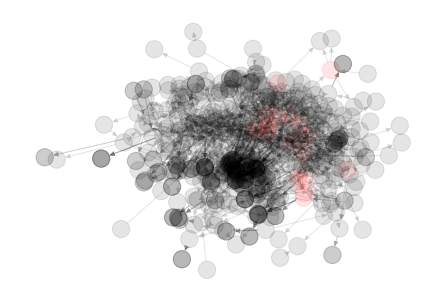

In [39]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

In [40]:
def Colour1(node):
    if np.sum(BLList.isin([node])):
        out = "red"
    elif np.sum(PLList.isin([node])):
        out = "blue"
    elif np.sum(SAList.isin([node])):
        out = "green" 
    elif np.sum(PDList.isin([node])):
        out = "yellow"
    elif np.sum(L1List.isin([node])):
        out = "purple"
    else:
        out = "none"
    return(out)

In [41]:
j = 0
for i in G.nodes:
    Colours[j] = Colour1(i)
    j = j+1

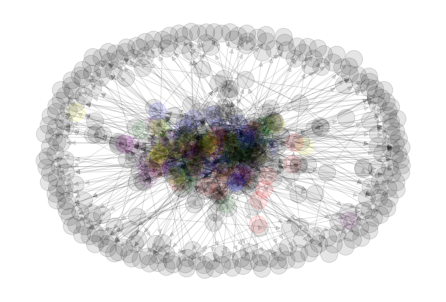

In [42]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)


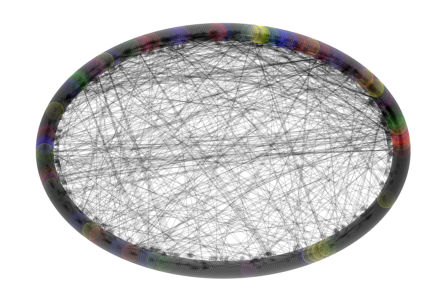

In [43]:
networkx.draw_circular(G,node_color = Colours, with_labels=False, alpha = 0.1)
# one can see blocks of the individual countries + crosslinks
#plt.savefig(year+"_Circular")

In [44]:
# Visual inspection: much less "Small World"-connected than before!

In [45]:
net = Network("800px", "800px",notebook=True)
net.from_nx(G)
net.show("Test.html")

## Pyvis

In [46]:
g = Network("800px", "800px",notebook=True)
g.toggle_physics(True)
G = nx.from_pandas_edgelist(DFun, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [47]:
def Colour(node):
    # from https://www.hexcolortool.com/#f429ff,0.33
    if np.sum(BLList.isin([node])):
        out = "rgba(244, 15, 11, 0.66)"
    elif np.sum(PLList.isin([node])):
        out = "rgba(41, 155, 255, 0.66)"
    elif np.sum(SAList.isin([node])):
        out = "rgba(41, 255, 77, 0.66)" 
    elif np.sum(PDList.isin([node])):
        out = "rgba(255, 241, 41, 0.66)"
    elif np.sum(L1List.isin([node])):
        out = "rgba(244, 41, 255, 0.66)"
    else:
        out = "rgba(0, 0, 0, 0.22)"
    return(out)

In [48]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {"physics":False
              })

In [49]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [50]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [51]:
for i in range(DFun.shape[0]):
    g.add_edge(DFun["club_name"].iloc[i], 
              DFun["club_involved_name"].iloc[i],
              value=DFun["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [52]:

#g.show_buttons(filter_=["nodes", "edges", "physics"])
g.show("Test.html")

In [53]:
#g.save_graph(year+"_allLeagues.html")

## Analysis

In [54]:
G_undir = nx.from_pandas_edgelist(DFun, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [55]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

#### Small World

In [56]:
## Small world

# random reference graph
#G_ref = networkx.algorithms.smallworld.random_reference(G_undir, seed = 10)
#DFcon19 = DFun19.iloc[DFun19["club_name"]!="SC Paderborn 07"]
#DFcon19 = DFcon19.iloc[DFcon19["club_involved_name"]!="SC Paderborn 07"]
SepList20 = ["CD Nacional", "Al-Batin", "Shimizu S-Pulse", "Portimonense SC", "SV Sandhausen",
            "CD Tondela", "Coventry"]
SepList19 = ["Vitória Setúbal FC","RKC Waalwijk","Portimonense SC","ADO Den Haag","Sparta Rotterdam",
             "FC Paços de Ferreira", "FK Ufa"]
SepList18 = ["CD Santa Clara", "Pau FC", "FC Emmen", "KS Samara","Khimki", "Tottenham Hotspurs",
            "C. Rizespor", "CD Nacional"]
SepList17 = ["Omiya Ardija", "SK Brann"]
SepList16 = ["FK Orenburg","Rotherham United","Belenenses SAD", "SC Heerenveen","MVV Maastricht",
            "Ross County", "GD Chaves"]
SepList15 = ["Boavista FC", "RSC Charleroi", "Helmond Sport","Lienden","Go Ahead Eagles"]
SepList14 = [ "Cracovia","Gaish","FK Ufa", "FC Nantes", "Brisbane Roar", "Shinnik"]
SepList13 = ["CFR Cluj","Zawisza","Académica Coimbra", "Tom Tomsk","Rio Ave FC","Alianza Lima",
             "Belenenses SAD","Waterford FC", "Leeds"]
SepList12 = ["Mordovia Saransk","Telstar", "CS Marítimo"]
SepList11 = ["Rio Ave FC","SC Olhanense","Sheriff", "Indjija"]
SepList10 = ["SM Caen","CS Marítimo","Sligo Rovers", "Roda JC Kerkrade", "Athletic Bilbao", 
             "Watford FC", "Cracovia","FK Rostov"]
SepList09 = ["AS Trencin", "Santo André","Anorthosis", "Sharjah FC"]
SepList08 = ["Ittihad"]
SepList07 = ["CF Estrela Amadora SAD"]


SepList = SepList07

DFcon= DFun.drop(DFun[ DFun['club_involved_name'].isin( SepList)].index)

DFcon = DFcon.drop(DFcon[ DFcon['club_name'].isin(SepList)].index)

#networkx.algorithms.smallworld.sigma(G_undir,niter=10, seed=10)

In [57]:
G_undirconnected = nx.from_pandas_edgelist(DFcon, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )




In [58]:
# Quick check: plot
nt = Network('800px', '800px',notebook=True)
#nt.from_nx(G_undirconnected)


for node in G_undirconnected.nodes:
    nt.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })
    
for i in range(DFcon.shape[0]):
    nt.add_edge(DFcon["club_name"].iloc[i], 
              DFcon["club_involved_name"].iloc[i],
              value=DFcon["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })

nt.show('nx.html')
# Is connected!!

In [59]:
#nt.save_graph(year+"_connection.html")


start = time.time()

SW = networkx.algorithms.smallworld.sigma(G_undirconnected,niter=20, seed=42)
print(SW)

end = time.time()
print(end - start)

#### Degree Distribution

In [60]:
networkx.classes.function.degree_histogram(G_undir)

[0,
 252,
 81,
 33,
 30,
 33,
 13,
 22,
 11,
 11,
 20,
 10,
 12,
 12,
 7,
 11,
 1,
 7,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1]

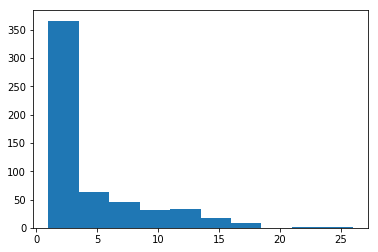

In [61]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G_undir)

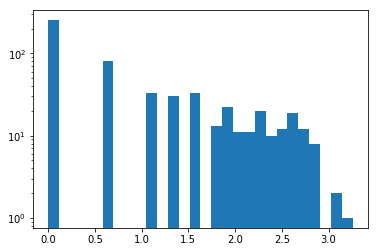

In [62]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(np.log(degrees), bins = int(len(G.nodes())/20), log = True)
    plt.show()

plot_degree_dist(G_undir)

In [63]:
degrees = [G.degree(n) for n in G.nodes()]
log_degrees = np.log(degrees)
print(np.mean(log_degrees), np.std(log_degrees), skew(log_degrees))


0.9017993478870286 0.9658332060259751 0.5782335235665407


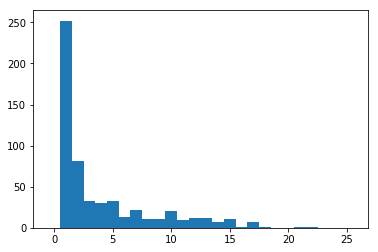

In [64]:
plt.hist(degrees, bins = np.arange(-0.5,max(degrees)+0.5,1))
plt.show()

In [65]:
degree_dist = np.zeros(max(degrees)+1)

In [66]:
for i in range(max(degrees)):
    degree_dist[i] = np.sum(np.array(degrees) == i)

In [67]:
degree_dist

array([  0., 252.,  81.,  33.,  30.,  33.,  13.,  22.,  11.,  11.,  20.,
        10.,  12.,  12.,   7.,  11.,   1.,   7.,   1.,   0.,   0.,   1.,
         1.,   0.,   0.,   0.,   0.])

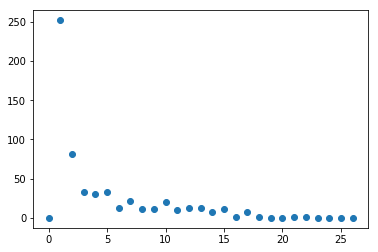

In [68]:
plt.scatter(np.arange(max(degrees)+1), degree_dist)
plt.show()

#### in-degree

0 83.0
1 258.0
2 84.0
3 41.0
4 24.0
5 27.0
6 15.0
7 19.0
8 6.0
9 4.0
10 2.0
11 4.0
12 1.0
13 1.0
14 1.0


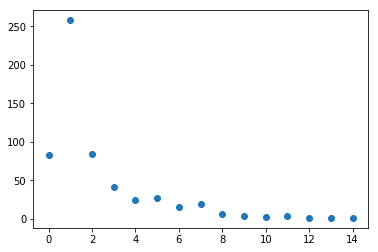

In [69]:
indegrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
indegree_dist = np.zeros(max(indegrees)+1)
for i in range(max(indegrees)+1):
    indegree_dist[i] = np.sum(np.array(indegrees) == i)
    print(i,indegree_dist[i])
plt.scatter(np.arange(max(indegrees)+1), indegree_dist)
plt.show()

In [70]:
# calculate for everything without 0 (artifact because of limited data)

In [71]:
indegree_dist

array([ 83., 258.,  84.,  41.,  24.,  27.,  15.,  19.,   6.,   4.,   2.,
         4.,   1.,   1.,   1.])

In [72]:
x = np.arange(1,max(indegrees)+1)
y = indegree_dist[1:]

Logical = (y!= 0) # else the linear regression has to deal with - infinity
print(x[Logical])

regIN = LinearRegression().fit(np.log(x[Logical]).reshape(-1, 1),
                               np.log(y[Logical]).reshape(-1, 1))


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


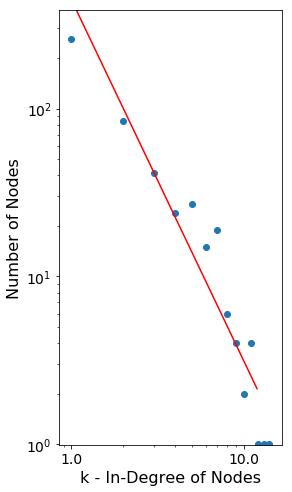

In [73]:
plt.figure(figsize=(4,8))
plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
xrange = np.arange(1.0, 12,0.1)
plt.plot(xrange,np.exp(regIN.predict(np.log(xrange.reshape(-1, 1)))), "red" )
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - In-Degree of Nodes", fontsize = 16)
plt.ylabel("Number of Nodes", fontsize = 16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.savefig(year+"_InNodeDistrPlot",bbox_inches='tight')

plt.show()

In [74]:
regIN.coef_

array([[-2.15551959]])

In [75]:
print(np.log(y[Logical]), 
               np.log(x[Logical]))

[5.55295958 4.4308168  3.71357207 3.17805383 3.29583687 2.7080502
 2.94443898 1.79175947 1.38629436 0.69314718 1.38629436 0.
 0.         0.        ] [0.         0.69314718 1.09861229 1.38629436 1.60943791 1.79175947
 1.94591015 2.07944154 2.19722458 2.30258509 2.39789527 2.48490665
 2.56494936 2.63905733]


In [76]:

X = np.log(x[Logical]).reshape(-1,1)
X =  sm.add_constant(X)
model = sm.OLS(np.log(y[Logical]), X)
resultIN = model.fit()
print(resultIN.bse[1])
print(resultIN.rsquared)



0.19516252077721571
0.9104386145039647


#### Out-Degree

In [77]:
outdegrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
outdegrees_dist = np.zeros(max(outdegrees)+1)
for i in range(max(outdegrees)+1):
    outdegrees_dist[i] = np.sum(np.array(outdegrees) == i)
    print(i,outdegrees_dist[i])


0 243.0
1 113.0
2 50.0
3 28.0
4 25.0
5 32.0
6 23.0
7 13.0
8 14.0
9 16.0
10 5.0
11 3.0
12 1.0
13 3.0
14 1.0


In [78]:
x = np.arange(1,max(outdegrees)+1)
y = outdegrees_dist[1:]


Logical = (y!=0)*(x>4) # else the linear regression has to deal with - infinity
                        # also x>4: Tail of distribution

regOUT = LinearRegression().fit(np.log(x[Logical]).reshape(-1, 1),
                               np.log(y[Logical]).reshape(-1, 1))


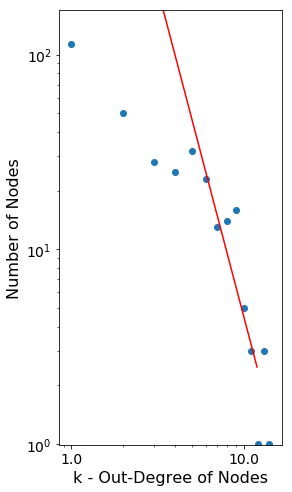

In [79]:
plt.figure(figsize=(4,8))
plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")
plt.plot(xrange,np.exp(regOUT.predict(np.log(xrange.reshape(-1, 1)))), "red" )
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - Out-Degree of Nodes", fontsize = 16)
plt.ylabel("Number of Nodes", fontsize = 16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.savefig(year+"_OutNodeDistrPlot",bbox_inches='tight')
plt.show()

In [80]:
regOUT.coef_[0][0]

-3.372028191419941

In [81]:

X = np.log(x[Logical]).reshape(-1,1)
X =  sm.add_constant(X)
model = sm.OLS(np.log(y[Logical]), X)
resultOUT= model.fit()
print(resultOUT.bse[1])
resultOUT.summary()

0.5257194389945508


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     41.14
Date:                Tue, 16 Nov 2021   Prob (F-statistic):           0.000206
Time:                        11:38:57   Log-Likelihood:                -6.8941
No. Observations:                  10   AIC:                             17.79
Df Residuals:                       8   BIC:                             18.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2614      1.170      7.917      0.000       6.564      11.959
x1            -3.3720      0.526     -6.414      0.000      -4.584      -2.160
==============================================================================
Omnibus:                        0.298   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.861   Jarque-Bera (JB):                0.085
Skew:                           0.149   Prob(JB):                        0.958
Kurtosis:                       2.662   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OutSlopes=pd.DataFrame(data = {"Slope In-Degree": regIN.coef_[0],
                               "StandError Slope In": resultIN.bse[1],
                               "R^2 In-Degree":resultIN.rsquared,
                    "Slope Out-Degree": regOUT.coef_[0],
                              "StandError Slope Out": resultOUT.bse[1],
                              "R^2 Out-Degree":resultOUT.rsquared})
OutSlopes
#OutSlopes.to_csv(year+"_slopes.csv",index=False)


### Clustering

In [82]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.DiGraph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [83]:
networkx.algorithms.hierarchy.flow_hierarchy(G_dir)

0.38991596638655457

In [84]:
# Regular Clustering

Clust = networkx.algorithms.cluster.clustering(G_dir)
BDN_C = np.mean(list(Clust.values()))
print(BDN_C)

0.018830721659992927


In [85]:
WeightClust = networkx.algorithms.cluster.clustering(G_dir, weight = "fee_cleaned")

In [86]:
# Weighted Clustering
# https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107

WDN_C = np.mean(list(WeightClust.values()))  ## ?
print(WDN_C)

0.0011178648139930746


In [87]:
NumberNodes = len(list(G_dir.nodes))
NumberEdges = len(list(G_dir.edges))

p = 2*NumberEdges / (NumberNodes*(NumberNodes-1)) # p. 19 in Large Scale Structures....
print(p)

0.007338204914747325


Kind of like Eq. (11) in https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107
it holds that Clustering_WDN < Clustering_BDN ~ p_random

### Calculate Node Strength Distribution

In [88]:
l=0
for n in G.nodes():
    l = l+1
print(l)
print(len(G.nodes()))
print(int(len(G.nodes())/20))

570
570
28


0.004 144.36


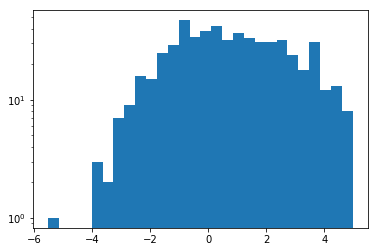

In [89]:
# Roughly symmetrical around 1.5?
def plot_strength_dist(G):
    strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
    plt.hist(np.log(strengths), bins = int(len(G.nodes())/20), log = True)
    print(min(strengths), max(strengths))
    #plt.savefig(year+"_LogStrengthDistrib")
    plt.show()
plot_strength_dist(G_dir)



In [90]:
strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
log_strengths = np.log(strengths)
print(np.mean(log_strengths), np.std(log_strengths), skew(log_strengths))

0.7638853498849539 1.9644054614194164 0.011692160757606224


### Disparity for undirected Network

In [91]:
A = networkx.linalg.graphmatrix.adjacency_matrix(G_undir, weight = "fee_cleaned")

In [92]:
print(A.shape)

(570, 570)


In [93]:
## Sanity check: should be 0
print(np.sum(A[i,i] for i in range(A.shape[0])))

0.0


/home/users/t_wand01/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [94]:
print(DF)

                    club_name  club_involved_name  fee_cleaned
0                  1. FC Köln  FC Energie Cottbus         0.45
1              1.FC Nuremberg        Sparta Praha         0.45
2              1.FC Nuremberg           Feyenoord         2.25
3              1.FC Nuremberg              Monaco         0.90
4              1.FC Nuremberg            OGC Nice         1.35
...                       ...                 ...          ...
1185  Wolverhampton Wanderers            Plymouth         2.03
1186                  Zamalek    Lokomotiv Moscow         1.26
1187     Zenit St. Petersburg          MSK Zilina         2.88
1188     Zenit St. Petersburg            KAA Gent         3.60
1189     Zenit St. Petersburg     Spartak Nalchik         1.80

[1190 rows x 3 columns]


In [95]:
print(A)

  (0, 1)	0.45
  (0, 59)	1.44
  (1, 0)	0.45
  (1, 8)	0.36
  (1, 59)	0.153
  (1, 72)	0.99
  (1, 78)	0.18
  (1, 292)	0.225
  (1, 293)	0.45
  (1, 294)	0.225
  (1, 295)	0.18
  (1, 296)	0.162
  (1, 297)	0.36
  (1, 399)	0.068
  (2, 3)	0.45
  (2, 4)	2.25
  (2, 5)	0.9
  (2, 6)	1.35
  (2, 7)	1.08
  (2, 11)	0.135
  (2, 12)	1.8
  (2, 30)	3.15
  (2, 279)	0.135
  (2, 378)	0.405
  (2, 390)	0.09
  :	:
  (546, 145)	0.315
  (547, 145)	0.675
  (547, 373)	2.88
  (548, 145)	0.135
  (549, 9)	0.18
  (550, 119)	0.81
  (551, 129)	0.72
  (552, 250)	0.045
  (553, 502)	0.068
  (554, 502)	0.18
  (555, 288)	0.198
  (556, 288)	0.153
  (557, 104)	0.045
  (558, 201)	0.248
  (559, 201)	0.27
  (560, 98)	7.02
  (561, 141)	0.9
  (562, 141)	0.81
  (563, 141)	0.743
  (564, 280)	1.17
  (565, 77)	0.45
  (566, 77)	0.135
  (567, 197)	0.675
  (568, 167)	1.26
  (569, 373)	3.6


In [96]:
strengths_undir = [G_undir.degree(n, weight="fee_cleaned") for n in G_undir.nodes()]

In [97]:
strengths_undir

[1.89,
 3.8030000000000004,
 11.745000000000001,
 3.6,
 29.700000000000003,
 29.43,
 11.52,
 120.24000000000002,
 8.802,
 40.614000000000004,
 29.075000000000003,
 2.088,
 13.14,
 19.044,
 6.300000000000001,
 53.19,
 16.470000000000002,
 36.36899999999999,
 23.526000000000003,
 144.36,
 11.593,
 0.72,
 19.8,
 100.703,
 11.039000000000001,
 84.35900000000002,
 34.309000000000005,
 0.72,
 7.7090000000000005,
 7.18,
 13.793,
 8.64,
 37.91,
 41.489999999999995,
 10.94,
 2.196,
 0.135,
 0.36,
 87.203,
 0.9,
 2.43,
 62.01000000000001,
 106.92,
 0.315,
 21.555,
 1.62,
 20.679000000000002,
 1.8910000000000002,
 0.36,
 0.18,
 17.523,
 72.89999999999999,
 2.0700000000000003,
 19.71,
 24.884999999999998,
 27.0,
 16.65,
 0.27,
 21.785,
 19.971,
 74.25,
 41.58,
 5.4,
 37.161,
 27.629999999999995,
 33.53,
 44.685,
 9.293,
 11.700000000000001,
 6.93,
 32.67,
 45.02000000000001,
 5.58,
 3.6,
 3.92,
 4.5,
 2.75,
 7.515,
 10.67,
 70.453,
 24.709999999999994,
 62.605000000000004,
 11.180000000000001,
 48

In [98]:
j = 0
Y = np.zeros(A.shape[0])
for i in G_undir.nodes:
    row = (A[j,:]/np.sum(A[j,:]))
    row = row.toarray()
    Y[j] = np.sum(row**2)
    j = j+1
    
    
print(j)

570


In [99]:
degrees_undir = [G_undir.degree(n) for n in G_undir.nodes()]

In [100]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.log(degrees_undir).reshape(-1, 1), np.log(Y).reshape(-1, 1))

In [101]:
print(reg.coef_[0]) # reasonably close to -1?


[-0.72100506]


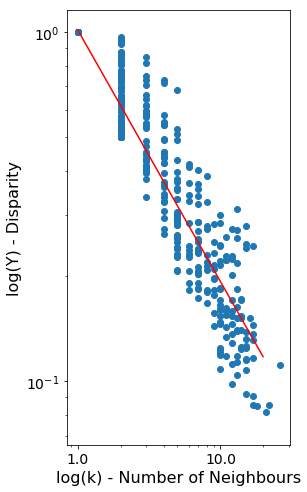

In [102]:


x = degrees_undir
y = Y
plt.figure(figsize=(4,8))
plt.scatter(x, y)
plt.xscale('log')
plt.yscale('log')

plt.plot(np.exp(np.arange(0,3,0.01)), 
        np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("log(k) - Number of Neighbours",fontsize=16)
plt.ylabel("log(Y) - Disparity",fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.savefig(year+"_DisparityPlot",bbox_inches='tight')

plt.show()


In [103]:

X = np.log(degrees_undir).reshape(-1, 1)
X =  sm.add_constant(X)
model = sm.OLS(np.log(Y), X)
resultDisp= model.fit()
print(resultDisp.bse[1])
print(resultDisp.rsquared)
resultDisp.summary()

0.0085388429954033
0.9262128755585775


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     7130.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):          9.88e-324
Time:                        11:38:58   Log-Likelihood:                 118.50
No. Observations:                 570   AIC:                            -233.0
Df Residuals:                     568   BIC:                            -224.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0170      0.011      1.510      0.132      -0.005       0.039
x1            -0.7210      0.009    -84.438      0.000      -0.738      -0.704
==============================================================================
Omnibus:                       70.998   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.597
Skew:                           0.755   Prob(JB):                     7.22e-29
Kurtosis:                       4.781   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
OutSlopes=pd.DataFrame(data = {"Slope In-Degree": regIN.coef_[0],
                               "StandError Slope In": resultIN.bse[1],
                               "R^2 In-Degree":resultIN.rsquared,
                    "Slope Out-Degree": regOUT.coef_[0],
                              "StandError Slope Out": resultOUT.bse[1],
                              "R^2 Out-Degree":resultOUT.rsquared,
                              "Slope Disparity": reg.coef_[0],
                              "StandError Disparity":resultDisp.bse[1] ,
                              "R^2 Disparity":resultDisp.rsquared})
print(OutSlopes)
OutSlopes.to_csv(year+"_slopes.csv",index=False)

   Slope In-Degree  StandError Slope In  R^2 In-Degree  Slope Out-Degree  \
0         -2.15552             0.195163       0.910439         -3.372028   

   StandError Slope Out  R^2 Out-Degree  Slope Disparity  \
0              0.525719        0.837203        -0.721005   

   StandError Disparity  R^2 Disparity  
0              0.008539       0.926213  


## Conclusion
Save some important results as an exported txt

In [105]:
Out = pd.DataFrame(data={"Year":year,
                         "NumberClubs": NumberNodes,
                         "NumberTransfers": DF_clean.shape[0],
                         "SmallWorld": SW,
                        "DisparityExponent": reg.coef_[0],
                         "BDN_RandomClusteringExpecation": p,
                        "BDN_Clustering": BDN_C,
                        "WDN_Clustering":WDN_C,
                        "MeanLogStrength":np.mean(log_strengths), 
                         "StdLogStrength":np.std(log_strengths), 
                         "SkewnessLogStrength":skew(log_strengths)})

NameError: name 'SW' is not defined

In [ ]:
#Out.to_csv(year+"_results.csv",index=False)

In [ ]:
Out

In [ ]:
year